### GPU access and Upload libraries:

In [1]:
#GPU:

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import tensorflow as tf

seed = 1

np.random.seed(1)
tf.random.set_seed(1)

2023-04-18 21:52:14.451975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch 
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from transformers import pipeline, set_seed
import textwrap
from pprint import pprint
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

### Download the Dataset:

In [5]:
!wget -nc http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

File ‘spa-eng.zip’ already there; not retrieving.



In [6]:
!unzip -nq spa-eng.zip #unzip the file

In [7]:
!ls 

(1) Hugging Face Algorithm.ipynb
(2) Sentiment Analysis_Airline Tweets.ipynb
(3) Text Generation_Robert Frost Poems.ipynb
(4) Article Spinning_BBC News Dataset.ipynb
(5)  Named Entity Recognition (NER) _ Carnell 2003 Dataset.ipynb
(6) Text Summarization_ BBC News Dataset.ipynb
(7) Machine Translation_English to Spanish Translator.ipynb
AirlineTweets.csv
bbc_text_cls.csv
ner_test.pkl
ner_train.pkl
robert_frost.txt
spa-eng
spa-eng.zip


In [8]:
!ls spa-eng #open the folder

_about.txt  spa.txt


In [9]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


### Some Data Preprocessing:

In [10]:
#dictionary type seems like a nice representation for tranlation purposes

eng2spa= {}
for line in open('spa-eng/spa.txt'):
    line = line.rstrip()
    eng, spa = line.split("\t")
    if eng not in eng2spa:
        eng2spa[eng] = []
    eng2spa[eng].append(spa)

In [11]:
eng2spa

{'Go.': ['Ve.', 'Vete.', 'Vaya.', 'Váyase.'],
 'Hi.': ['Hola.'],
 'Run!': ['¡Corre!'],
 'Run.': ['Corred.'],
 'Who?': ['¿Quién?'],
 'Fire!': ['¡Fuego!', '¡Incendio!', '¡Disparad!'],
 'Help!': ['¡Ayuda!', '¡Socorro! ¡Auxilio!', '¡Auxilio!'],
 'Jump!': ['¡Salta!'],
 'Jump.': ['Salte.'],
 'Stop!': ['¡Parad!', '¡Para!', '¡Pare!'],
 'Wait!': ['¡Espera!'],
 'Wait.': ['Esperen.'],
 'Go on.': ['Continúa.', 'Continúe.'],
 'Hello!': ['Hola.'],
 'I ran.': ['Corrí.', 'Corría.'],
 'I try.': ['Lo intento.'],
 'I won!': ['¡He ganado!'],
 'Oh no!': ['¡Oh, no!'],
 'Relax.': ['Tomátelo con soda.'],
 'Smile.': ['Sonríe.'],
 'Attack!': ['¡Al ataque!', '¡Atacad!'],
 'Get up.': ['Levanta.'],
 'Go now.': ['Ve ahora mismo.'],
 'Got it!': ['¡Lo tengo!'],
 'Got it?': ['¿Lo pillas?', '¿Entendiste?'],
 'He ran.': ['Él corrió.'],
 'Hop in.': ['Métete adentro.'],
 'Hug me.': ['Abrázame.'],
 'I fell.': ['Me caí.'],
 'I know.': ['Yo lo sé.'],
 'I left.': ['Salí.'],
 'I lied.': ['Mentí.'],
 'I lost.': ['Perdí.'],
 'I 

### Fiddling with the BLEU Evaluation:

In [12]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer #this tokenzier removes punctuations, so it hels keeping things simple. Plus, 
#The bleu score works with tokens, not raw text. 

tekenizer = RegexpTokenizer(r'\w+')

In [13]:
#let's test the tokenizer with a spanish sample sentence:
tokens = tekenizer.tokenize('¿Qué me cuentas?'.lower())
tokens

['qué', 'me', 'cuentas']

In [14]:
#evaluate the last spanish sample sentence:
sentence_bleu([tokens], tokens)

/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1.2213386697554703e-77

In [15]:
sentence_bleu([['hi']], ['hi'])

/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1.821831989445342e-231

In [16]:
smoother = SmoothingFunction()
sentence_bleu(['hi'], 'hi', smoothing_function=smoother.method4) 
#doesn't make much intuitive sense, as we can clearly see that 

0.2213885886251307

In [17]:
sentence_bleu([[1, 2, 3, 4]], [1, 2, 3, 4]) #since we have 4-grams which is more than 2-grams, then we don't get that error above.

1.0

### Tokenizing the target (aka. the Spanish text/words) for the BLEU Evaluation:

In [18]:
eng2spa_tokenized = {}

for eng, spa_lst in eng2spa.items(): #accessing both key and value of the dictionary
    spa_lst_tokens = []
    for spa in spa_lst:
        tokens = tekenizer.tokenize(spa.lower())
        spa_lst_tokens.append(tokens)
    eng2spa_tokenized[eng] = spa_lst_tokens

In [19]:
! pip install transformers sentencepiece transformers[sentencepiece]

In [20]:
translator = pipeline("translation", model='Helsinki-NLP/opus-mt-en-es', device=0)

/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [21]:
translator('Ilike eggs and ham')

[{'translation_text': 'Me gustan los huevos y el jamón'}]

### Model Evaluation:

In [23]:
eng_phrases = list(eng2spa.keys())
len(eng_phrases)

102904

In [24]:
#choosing a sample of say size 100
#the reason for choosing 20000 to 20100 speciafially is because there are longer phrases here which 
#the BLEU score won't show a warning again regarding 2-grams. 
eng_phrases_subset = eng_phrases[20000:20100]

In [25]:
translations = translator(eng_phrases_subset)

In [27]:
translations[0]

{'translation_text': 'Tom está en el jardín.'}

In [28]:
#computing the BLEU scores:

scores = []
for eng, pred in zip(eng_phrases_subset, translations):
    matched_spa_original = eng2spa_tokenized[eng]
    preds_spa = tekenizer.tokenize(pred['translation_text'].lower())
    score = sentence_bleu(matched_spa_original, preds_spa)
    scores.append(score)

/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tinagh/anaconda3/envs/mytfenv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

In [32]:
scores

[1.0,
 1.0,
 8.17527103954383e-155,
 8.636168555094496e-78,
 1.0,
 1.0547686614863434e-154,
 7.380245217279165e-78,
 1.0,
 1.0547686614863434e-154,
 1.2213386697554703e-77,
 1.0547686614863434e-154,
 7.380245217279165e-78,
 0.668740304976422,
 1.0,
 1.0,
 1.0,
 9.975386110402101e-155,
 1.1862800137389335e-154,
 1.0,
 9.918892480173173e-232,
 1.1795617510369435e-231,
 1.1795617510369435e-231,
 1.1795617510369435e-231,
 8.636168555094496e-78,
 5.819186114595022e-155,
 1.0,
 1.1862800137389335e-154,
 8.636168555094496e-78,
 1.0,
 1.0,
 8.636168555094496e-78,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.2213386697554703e-77,
 1.0,
 1.0,
 1.0,
 0.41113361690051975,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0032743411283238e-231,
 1.1640469867513693e-231,
 7.380245217279165e-78,
 0.5789300674674098,
 1.0,
 0.7598356856515925,
 1.2213386697554703e-77,
 1.133422688662942e-154,
 1.1795617510369435e-231,
 1.2213386697554703e-77,
 9.53091075863908e-155,
 1.4488496539373276e-231,
 7.227401369829121e-

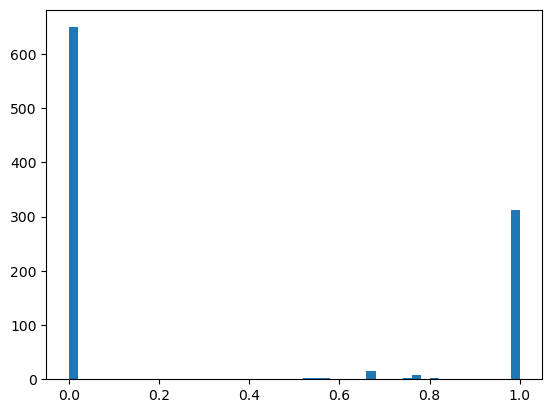

In [30]:
plt.hist(scores,bins = 50)
plt.show() #-> I am not sure why atm but there is something wrong with this plot, the 1s should be much more. Maybe I had a typo somwehere?

In [31]:
np.mean(scores)

0.3383504014386889

### Printing random translation results:

In [35]:
np.random.seed(1)

def print_random_translation():
    i = np.random.choice(len(eng_phrases_subset))
    eng = eng_phrases_subset[i]
    print("EN: ", eng)
    
    transl = translations[i]['translation_text']
    print("ES Translation: ", transl)
    
    matches = eng2spa[eng]
    print("Matches: ", matches)
    

In [36]:
print_random_translation()

EN:  Tom isn't that young.
ES Translation:  Tom no es tan joven.
Matches:  ['Tom no es tan joven.']


In [37]:
print_random_translation()

EN:  Tom's Mary's brother.
ES Translation:  Tom es el hermano de Mary.
Matches:  ['Tom es el hermano de Mary.']
